In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u432-ga~us1-0ubuntu2~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u432-ga~us1-0ub

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


Via our EDA analysis, the following was found:


> Features most correlated with Addiction Level:
*   Satisfaction                0.994939

Satisfaction is likely redundant, as it seems to provide nearly identical information to addiction level.

Thus, this column will not be accounted for in our models.
I also removed ProductivityLoss, as it's essentially a result of Addiction Level (highly correlated)

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# Start Spark session
spark = SparkSession.builder.appName("AddictionLevelPrediction").getOrCreate()

Define a helper function to normalize columns

In [5]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import DenseVector
# normalize column
def normalizeColumn(col_name, df):
  vector_col_name = f'{col_name}_vector'
  scaled_col_name = f's{col_name}'
  vector_assembler = VectorAssembler(inputCols=[col_name], outputCol=vector_col_name)
  df = vector_assembler.transform(df)
  scaler = MinMaxScaler(inputCol=vector_col_name, outputCol=scaled_col_name)
  scaler_model = scaler.fit(df)
  df = scaler_model.transform(df)

  # Define a UDF to extract the first element of the vector
  def extract_first_element(vec):
      # Ensure the input is a DenseVector and extract the first element
      if isinstance(vec, DenseVector):
          return float(vec[0])
      return None

  # Register the UDF
  extract_first_element_udf = udf(extract_first_element, FloatType())

  # Apply the UDF to extract the first value from the 'sIncome' vector and create a new column 'Income'
  df = df.withColumn(col_name, extract_first_element_udf(scaled_col_name))

  # Drop the temporary columns to clean up
  df = df.drop(vector_col_name, scaled_col_name)
  return df
# wrapper on normalizeColumn to normalize multiple columns
def normalizeColumns(col_names, df):
  for name in col_names:
    df = normalizeColumn(name, df)
  return df

**Random Forest Classifier**

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)

# Normalize Columns
tw_df = normalizeColumn("Income", tw_df)
tw_df = normalizeColumn("Engagement", tw_df)

# Categorical Features
categorical_cols = ["Gender", "Location", "Profession", "Demographics", "Platform", "Frequency",
                    "Watch Reason", "DeviceType", "CurrentActivity", "ConnectionType"]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index").fit(tw_df) for col in categorical_cols]

# Assemble Features (Numerical + Categorical)
numerical_cols = ["Age", "Income", "Debt", "Owns Property", "Total Time Spent", "Number of Sessions",
                  "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
                  "Number of Videos Watched", "Scroll Rate", "Self Control"]

assembled_cols = [f"{col}Index" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")

# Index Target Column
label_indexer = StringIndexer(inputCol="Addiction Level", outputCol="label").fit(tw_df)

# Define the RandomForestClassifier
rf_t = RandomForestClassifier(featuresCol="features", labelCol="label", seed=1)

# Create Pipeline
pipeline = Pipeline(stages=indexers + [assembler, label_indexer, rf_t])

# Split Data
train_data, test_data = tw_df.randomSplit([0.7, 0.3], seed=1)

# Define Hyperparameter Grid
param_grid = (ParamGridBuilder()
              .addGrid(rf_t.numTrees, [10, 50, 100])
              .addGrid(rf_t.maxDepth, [5, 10, 20])
              .addGrid(rf_t.minInstancesPerNode, [1, 5, 10])
              .addGrid(rf_t.maxBins, [16, 32, 64])
              .build())

# Set up Cross-Validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=3)  # 3-fold cross-validation

# Train the Model
cv_model = cv.fit(train_data)

# Make Predictions
predictions = cv_model.transform(test_data)

# Evaluate the Best Model
accuracy = evaluator.evaluate(predictions)
print(f"Best Model Accuracy: {accuracy:.2f}")



Best Model Accuracy: 0.98


Best Model Hyperparameters:
- numTrees: 100
- maxDepth: 20
- minInstancesPerNode: 1
- maxBins: 64


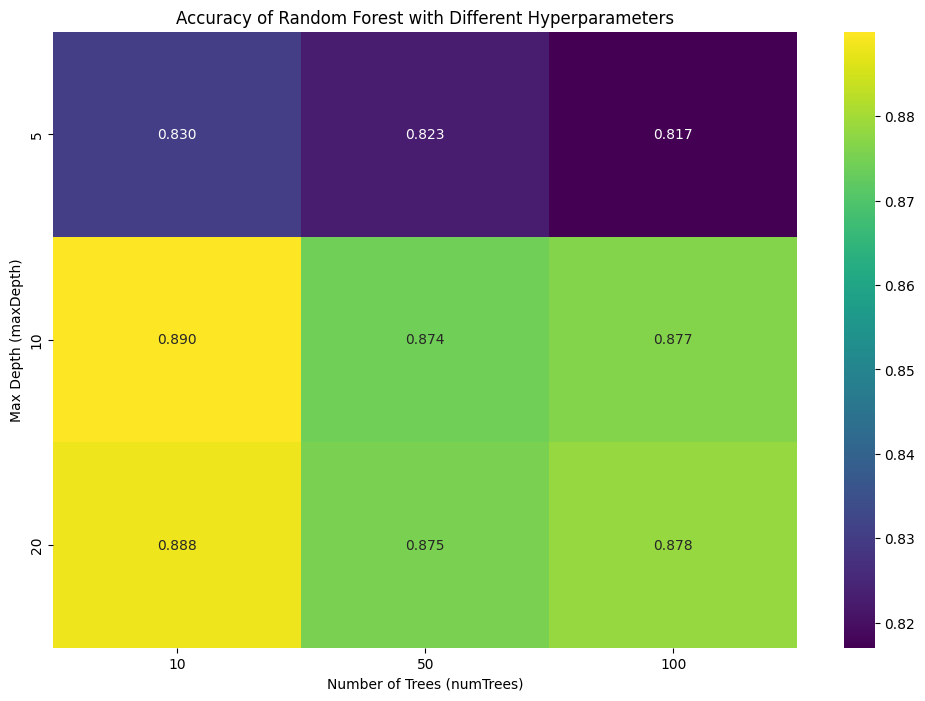

In [ ]:
# Extract the Best Model's Hyperparameters

best_model = cv_model.bestModel
best_rf_model = best_model.stages[-1]  # Random Forest is the last stage

# Extract parameter values from the best Random Forest model
params = best_rf_model.extractParamMap()
print(f"Best Model Hyperparameters:\n"
      f"- numTrees: {params[best_rf_model.numTrees]}\n"
      f"- maxDepth: {params[best_rf_model.maxDepth]}\n"
      f"- minInstancesPerNode: {params[best_rf_model.minInstancesPerNode]}\n"
      f"- maxBins: {params[best_rf_model.maxBins]}")

# Plot the Results
# Extract cross-validation results and the corresponding hyperparameters
metrics = []

# Collect accuracy and corresponding hyperparameters
for idx, param_map in enumerate(cv_model.getEstimatorParamMaps()):
    metrics.append({
        "accuracy": cv_model.avgMetrics[idx],
        "numTrees": param_map[rf_t.numTrees],
        "maxDepth": param_map[rf_t.maxDepth]
    })

# Convert metrics to a DataFrame
import pandas as pd
metrics_df = pd.DataFrame(metrics)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df.pivot_table(index="maxDepth", columns="numTrees", values="accuracy"),
            annot=True, cmap="viridis", fmt=".3f")
plt.title("Accuracy of Random Forest with Different Hyperparameters")
plt.xlabel("Number of Trees (numTrees)")
plt.ylabel("Max Depth (maxDepth)")
plt.show()


Seems like the best params seem to be as follows:


*   numTrees: 100
*   maxDepth: 20
*   minInstancesPerNode: 1
*   maxBins: 64

In [44]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml import Pipeline

# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)

# Preprocessing: Normalize Columns
tw_df = normalizeColumns(["Income", "Engagement"], tw_df)

# Handle Categorical Features (Encode and Index)
categorical_cols = ["Gender", "Location", "Profession", "Demographics", "Platform", "Frequency",
                    "Watch Reason", "DeviceType", "CurrentActivity", "ConnectionType", "Self Control"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index").fit(tw_df) for col in categorical_cols]



# Assemble Features (Numerical + Categorical)
numerical_cols = ["Age", "Income", "Debt", "Owns Property", "Total Time Spent", "Number of Sessions",
                  "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
                  "Number of Videos Watched", "Scroll Rate"]
assembled_cols = [f"{col}Index" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")

# Index Target Column
label_indexer = StringIndexer(inputCol="Addiction Level", outputCol="label").fit(tw_df)

# Feature Selection using Chi-Squared Test
# selector = ChiSqSelector(numTopFeatures=10, featuresCol="features", outputCol="selected_features", labelCol="label")

# Model and Pipeline (After Feature Selection)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100,
                             maxDepth=20, minInstancesPerNode=1, maxBins=64, seed=1)

# Create pipeline with all stages: indexing, assembling, feature selection, and training
pipeline = Pipeline(stages=indexers + [assembler, label_indexer, rf])

# Split Data
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train Model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)
predictions.select("label", "prediction").show(5)

# Evaluate Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Accuracy without ohe: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



+-----+----------+
|label|prediction|
+-----+----------+
|  2.0|       2.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows

Accuracy: 0.96


with chi-squared test

In [48]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml import Pipeline

# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)

# Preprocessing: Normalize Columns
tw_df = normalizeColumns(["Income", "Engagement"], tw_df)

# Handle Categorical Features (Encode and Index)
categorical_cols = ["Location","Frequency"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index").fit(tw_df) for col in categorical_cols]



# Assemble Features (Numerical + Categorical)
numerical_cols = ["Age", "Income", "Total Time Spent",
                "Engagement", "Time Spent On Video",
                  "Scroll Rate",]
assembled_cols = [f"{col}Index" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")

# Index Target Column
label_indexer = StringIndexer(inputCol="Addiction Level", outputCol="label").fit(tw_df)

# Model and Pipeline (After Feature Selection)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100,
                             maxDepth=20, minInstancesPerNode=1, maxBins=64, seed=1)

# Create pipeline with all stages: indexing, assembling, feature selection, and training
pipeline = Pipeline(stages=indexers + [assembler, label_indexer, rf])

# Split Data
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train Model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)
predictions.select("label", "prediction").show(5)

# Evaluate Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Accuracy without ohe: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



+-----+----------+
|label|prediction|
+-----+----------+
|  2.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows

Accuracy: 0.49


test feature importance

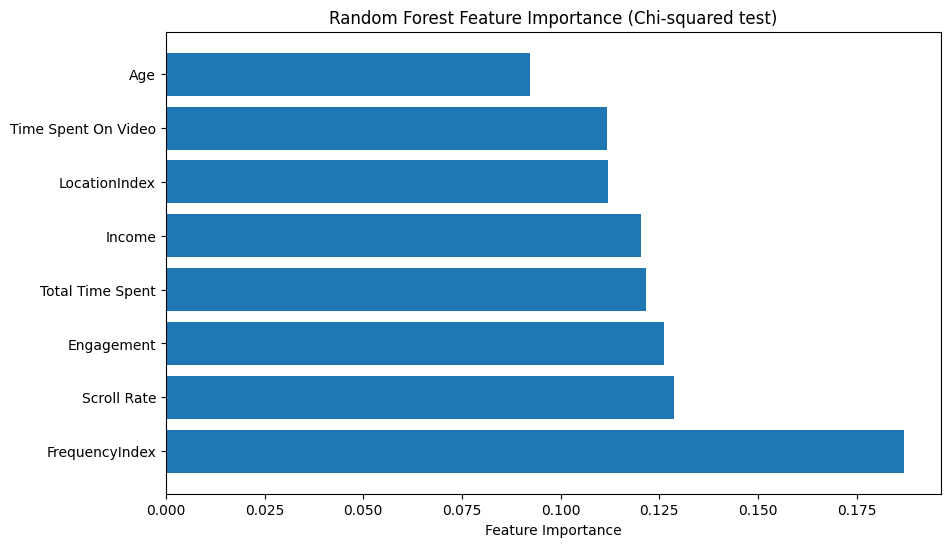

In [50]:
# Access the trained Random Forest model
rf_model = model.stages[-1]  # The last stage is the RandomForestModel

# Get the feature importances
importances = rf_model.featureImportances

# Get the feature names (which are the same as the ones in assembled_cols)
feature_names = assembled_cols

# Sort the features by their importance
sorted_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Prepare data for visualization
import matplotlib.pyplot as plt

# Extract feature names and their importance values
features, importance_values = zip(*sorted_importances)

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importance_values)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Chi-squared test)')
plt.show()

Random forest model ends up with an accuracy of 96%.
Well that's a little too high, let's find out why

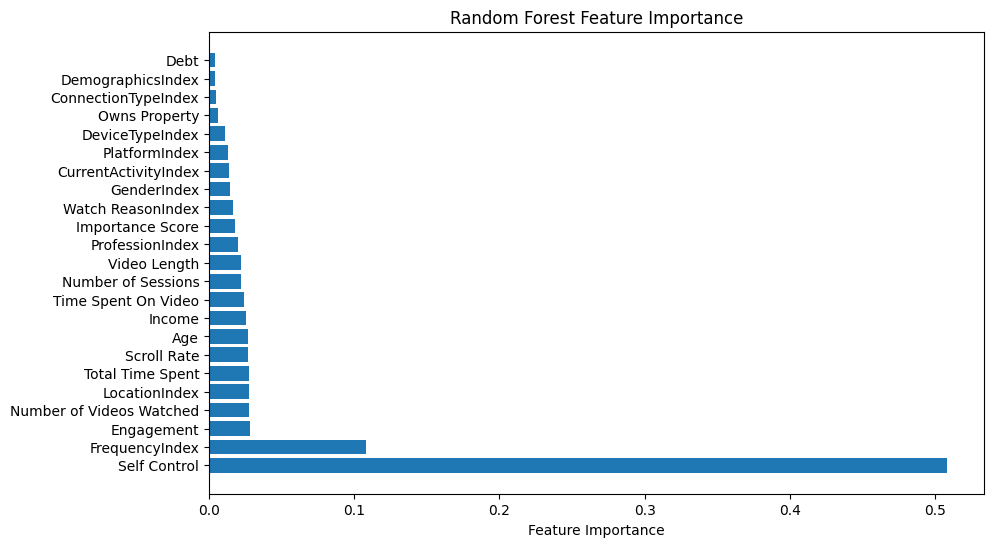

In [47]:
# Access the trained Random Forest model
rf_model = model.stages[-1]  # The last stage is the RandomForestModel

# Get the feature importances
importances = rf_model.featureImportances

# Get the feature names (which are the same as the ones in assembled_cols)
feature_names = assembled_cols

# Sort the features by their importance
sorted_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Prepare data for visualization
import matplotlib.pyplot as plt

# Extract feature names and their importance values
features, importance_values = zip(*sorted_importances)

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importance_values)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


Ah! it seems Self Control plays a really big role, maybe by removing it our accuracy won't be as high.

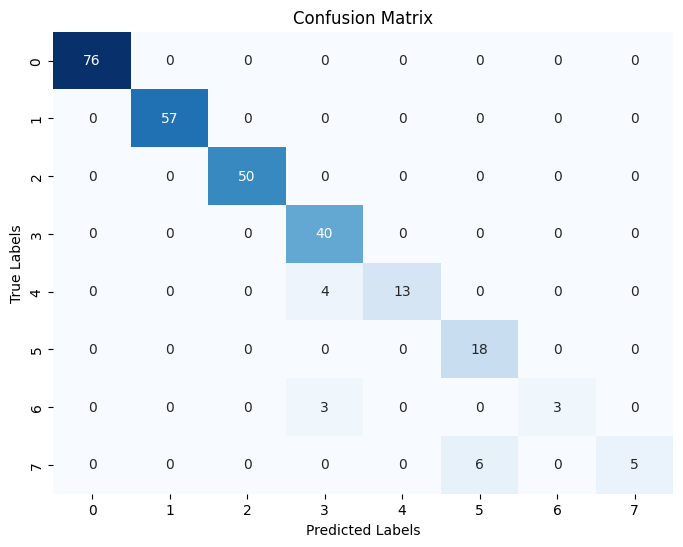

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Get predictions and labels
pred_labels = predictions.select("label").rdd.flatMap(lambda x: x).collect()
pred_preds = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Convert to numpy arrays
import numpy as np
conf_matrix = confusion_matrix(pred_labels, pred_preds)

# Convert to a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


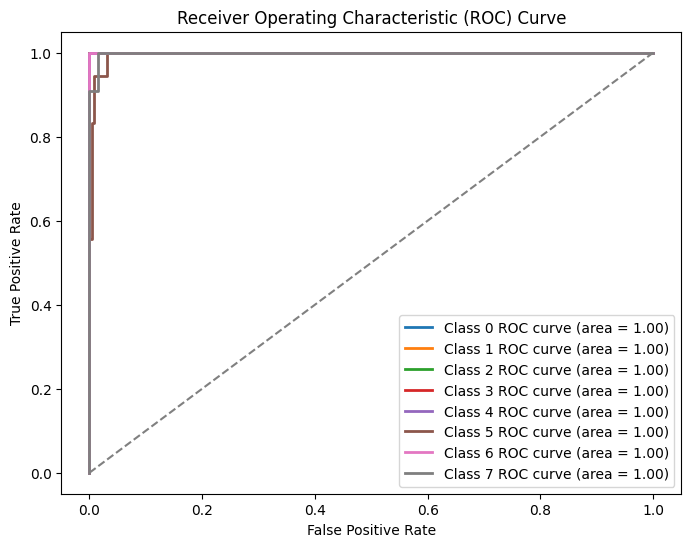

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import DenseVector
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
def plotROC():
  # Get prediction probabilities
  pred_probs = predictions.select("probability").rdd.map(lambda x: x[0]).collect()

  # True labels
  true_labels = predictions.select("label").rdd.map(lambda x: x[0]).collect()

  # Convert predictions to numpy array
  true_labels = np.array(true_labels)
  pred_probs = np.array([prob.toArray() for prob in pred_probs])

  # Number of classes (based on the label column)
  num_classes = pred_probs.shape[1]

  # Plot ROC curve for each class
  plt.figure(figsize=(8, 6))

  for i in range(num_classes):
      # Compute ROC curve for each class, using one-vs-rest strategy
      fpr, tpr, _ = roc_curve(true_labels, pred_probs[:, i], pos_label=i)

      # Compute AUC
      roc_auc = auc(fpr, tpr)

      # Plot ROC curve for the current class
      plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

  # Plot the diagonal line (chance level)
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

  # Labels and title
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")

  # Show plot
  plt.show()
plotROC()

Let's try removing the Self Control feature and see what happens.

In [ ]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml import Pipeline

# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)

# Preprocessing: Normalize Columns
tw_df = normalizeColumns(["Income", "Engagement"], tw_df)

# Handle Categorical Features (Encode and Index)
categorical_cols = ["Gender", "Location", "Profession", "Demographics", "Platform", "Frequency",
                    "Watch Reason", "DeviceType", "CurrentActivity", "ConnectionType"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index").fit(tw_df) for col in categorical_cols]



# Assemble Features (Numerical + Categorical)
numerical_cols = ["Age", "Income", "Debt", "Owns Property", "Total Time Spent", "Number of Sessions",
                  "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
                  "Number of Videos Watched", "Scroll Rate"]
assembled_cols = [f"{col}Index" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")

# Index Target Column
label_indexer = StringIndexer(inputCol="Addiction Level", outputCol="label").fit(tw_df)

# Feature Selection using Chi-Squared Test
selector = ChiSqSelector(numTopFeatures=10, featuresCol="features", outputCol="selected_features", labelCol="label")

# Model and Pipeline (After Feature Selection)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50,
                             maxDepth=10, minInstancesPerNode=1, maxBins=32, seed=1)

# Create pipeline with all stages: indexing, assembling, feature selection, and training
pipeline = Pipeline(stages=indexers + [assembler, label_indexer, selector, rf])

# Split Data
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train Model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)
predictions.select("label", "prediction").show(5)

# Evaluate Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")


+-----+----------+
|label|prediction|
+-----+----------+
|  2.0|       2.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows

Accuracy: 0.51


The accuracy drastically drops when we remove "Self Control" -- 96% to 51%.

Let's try to map "Addiction Level" values to categories


*   0-2 = Low
*   3-5 = Medium
*   6-7 = High





In [ ]:
# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = tw_df.withColumn(
    "Addiction Category",
    when((tw_df["Addiction Level"] >= 0) & (tw_df["Addiction Level"] <= 2), "Low")
    .when((tw_df["Addiction Level"] >= 3) & (tw_df["Addiction Level"] <= 5), "Medium")
    .when((tw_df["Addiction Level"] >= 6) & (tw_df["Addiction Level"] <= 7), "High")
)
tw_df.select("Addiction Category").show(3)

+------------------+
|Addiction Category|
+------------------+
|            Medium|
|            Medium|
|               Low|
+------------------+
only showing top 3 rows



After testing with addiction level "categories", the accuracy jumps up to 68% --from 51%.
hmm, this is still not exactly what we want.
Let's put the Self Control feature back in, and add some noise

In [8]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml import Pipeline

# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = tw_df.withColumn(
    "Addiction Category",
    when((tw_df["Addiction Level"] >= 0) & (tw_df["Addiction Level"] <= 2), "Low")
    .when((tw_df["Addiction Level"] >= 3) & (tw_df["Addiction Level"] <= 5), "Medium")
    .when((tw_df["Addiction Level"] >= 6) & (tw_df["Addiction Level"] <= 7), "High")
)
# Preprocessing: Normalize Columns
tw_df = normalizeColumns(["Income", "Engagement"], tw_df)

# Introduce noise into the "Self Control" feature by adding random noise
tw_df = tw_df.withColumn("Self Control", tw_df["Self Control"] + (rand() * 0.1 - 0.05))  # Add noise within range [-0.05, 0.05]

# Handle Categorical Features (Encode and Index)
categorical_cols = ["Gender", "Location", "Profession", "Demographics", "Platform", "Frequency",
                    "Watch Reason", "DeviceType", "CurrentActivity", "ConnectionType"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index").fit(tw_df) for col in categorical_cols]

# Assemble Features (Numerical + Categorical)
numerical_cols = ["Age", "Income", "Debt", "Owns Property", "Total Time Spent", "Number of Sessions",
                  "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
                  "Number of Videos Watched", "Scroll Rate", "Self Control"]
assembled_cols = [f"{col}Index" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")

# Index Target Column
label_indexer = StringIndexer(inputCol="Addiction Category", outputCol="label").fit(tw_df)

# Feature Selection using Chi-Squared Test. --- let's uhh not use this rn
# selector = ChiSqSelector(numTopFeatures=10, featuresCol="features", outputCol="selected_features", labelCol="label")

# Model and Pipeline (After Feature Selection)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=30,
                             maxDepth=5, minInstancesPerNode=1, maxBins=32, seed=1)

# Create pipeline with all stages: indexing, assembling, feature selection, and training
pipeline = Pipeline(stages=indexers + [assembler, label_indexer, rf])

# Split Data
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train Model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)
predictions.select("label", "prediction").show(5)

# Evaluate Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Accuracy without ohe: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
+-----+----------+
only showing top 5 rows

Accuracy without ohe: 0.93
Precision: 0.93
Recall: 0.93
F1 Score: 0.92


Now, with OHE (One Hot Encoding)

In [10]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = tw_df.withColumn(
    "Addiction Category",
    when((tw_df["Addiction Level"] >= 0) & (tw_df["Addiction Level"] <= 2), "Low")
    .when((tw_df["Addiction Level"] >= 3) & (tw_df["Addiction Level"] <= 5), "Medium")
    .when((tw_df["Addiction Level"] >= 6) & (tw_df["Addiction Level"] <= 7), "High")
)
# Preprocessing
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Introduce noise into the "Self Control" feature by adding random noise
tw_df = tw_df.withColumn("Self Control", tw_df["Self Control"] + (rand() * 0.1 - 0.05))  # Add noise within range [-0.05, 0.05]

# Handle Categorical Features (Encode and Index)
categorical_cols = ["Gender", "Location", "Profession", "Demographics", "Platform", "Frequency",
                    "Watch Reason", "DeviceType", "CurrentActivity", "ConnectionType"]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index").fit(tw_df) for col in categorical_cols]

# OneHotEncoder for the indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}Index", outputCol=f"{col}OneHot") for col in categorical_cols]

# Numerical columns (excluding some like Satisfaction)
numerical_cols = ["Age", "Income", "Debt", "Owns Property", "Total Time Spent", "Number of Sessions",
                  "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
                  "Number of Videos Watched", "Scroll Rate", "Self Control"]

# Combine all encoded categorical columns and numerical columns
assembled_cols = [f"{col}OneHot" for col in categorical_cols] + numerical_cols

# VectorAssembler to combine features into a single vector
assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")

# Index Target Column (Addiction Level)
label_indexer = StringIndexer(inputCol="Addiction Category", outputCol="label").fit(tw_df)

# Model and Pipeline (After Feature Selection)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=30,
                             maxDepth=5, minInstancesPerNode=1, maxBins=32, seed=1)

# Create Pipeline with indexers, encoders, assembler, label indexer, and model
pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer, rf])

# Split Data into Training and Test sets
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train the Model
model = pipeline.fit(train_data)

# Make Predictions
predictions = model.transform(test_data)
predictions.select("label", "prediction").show(5)

# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Accuracy with ohe: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows

Accuracy with ohe: 0.89
Precision: 0.91
Recall: 0.89
F1 Score: 0.85


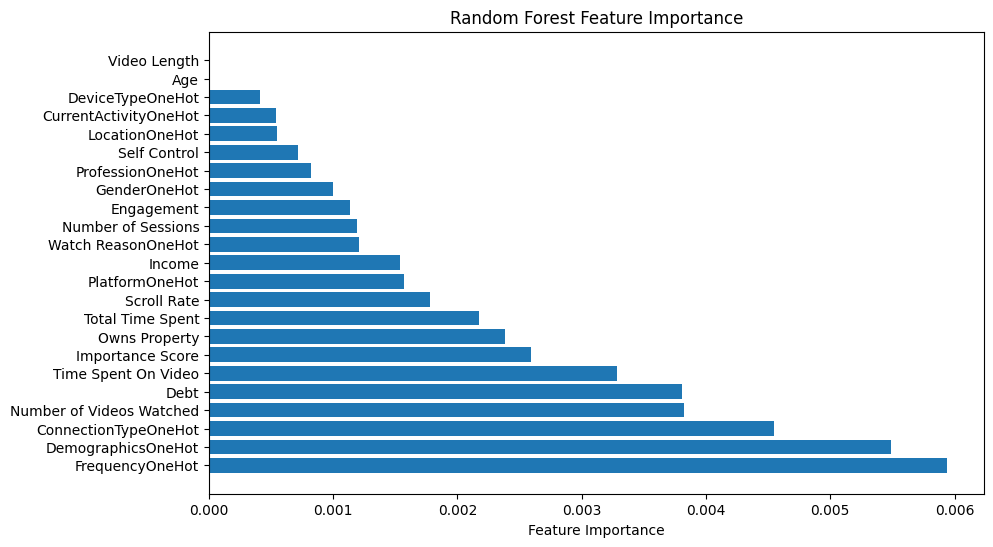

In [11]:
# Access the trained Random Forest model
rf_model = model.stages[-1]  # The last stage is the RandomForestModel

# Get the feature importances
importances = rf_model.featureImportances

# Get the feature names (which are the same as the ones in assembled_cols)
feature_names = assembled_cols

# Sort the features by their importance
sorted_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Prepare data for visualization
import matplotlib.pyplot as plt

# Extract feature names and their importance values
features, importance_values = zip(*sorted_importances)

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importance_values)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()



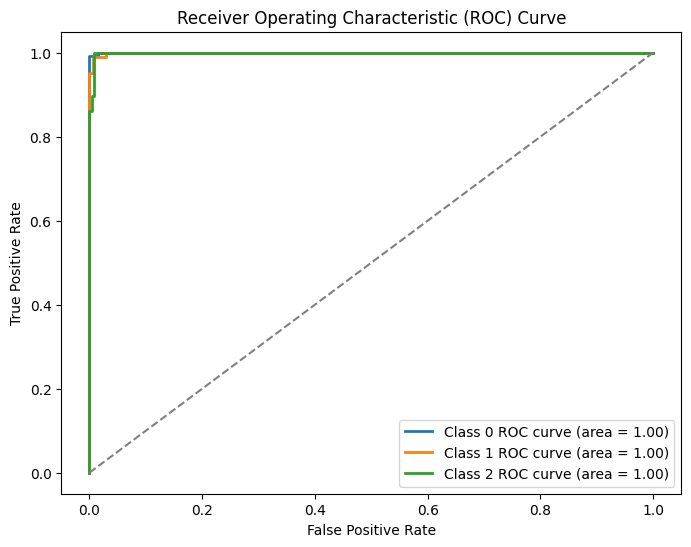

In [ ]:
plotROC()

Out of curiosity let's see how well our model predicts the numeric addiction level 0-7

In [20]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)

# Preprocessing
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Introduce noise into the "Self Control" feature by adding random noise
tw_df = tw_df.withColumn("Self Control", tw_df["Self Control"] + (rand() * 0.1 - 0.05))  # Add noise within range [-0.05, 0.05]

# Handle Categorical Features (Encode and Index)
categorical_cols = ["Gender", "Location", "Profession", "Demographics", "Platform", "Frequency",
                    "Watch Reason", "DeviceType", "CurrentActivity", "ConnectionType"]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index").fit(tw_df) for col in categorical_cols]

# OneHotEncoder for the indexed columns
encoders = [OneHotEncoder(inputCol=f"{col}Index", outputCol=f"{col}OneHot") for col in categorical_cols]

# Numerical columns (excluding some like Satisfaction)
numerical_cols = ["Age", "Income", "Debt", "Owns Property", "Total Time Spent", "Number of Sessions",
                  "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
                  "Number of Videos Watched", "Scroll Rate", "Self Control"]

# Combine all encoded categorical columns and numerical columns
assembled_cols = [f"{col}OneHot" for col in categorical_cols] + numerical_cols

# VectorAssembler to combine features into a single vector
assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")

# Index Target Column (Addiction Level)
label_indexer = StringIndexer(inputCol="Addiction Level", outputCol="label").fit(tw_df)

# Model and Pipeline (After Feature Selection)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=30,
                             maxDepth=5, minInstancesPerNode=1, maxBins=32, seed=1)

# Create Pipeline with indexers, encoders, assembler, label indexer, and model
pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer, rf])

# Split Data into Training and Test sets
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train the Model
model = pipeline.fit(train_data)

# Make Predictions
predictions = model.transform(test_data)
predictions.select("label", "prediction").show(5)

# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy with ohe: {accuracy:.2f}")

# Load Data
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)

# Preprocessing
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Introduce noise into the "Self Control" feature by adding random noise
tw_df = tw_df.withColumn("Self Control", tw_df["Self Control"] + (rand() * 0.1 - 0.05))  # Add noise within range [-0.05, 0.05]

# Handle Categorical Features (Encode and Index)
categorical_cols = ["Gender", "Location", "Profession", "Demographics", "Platform", "Frequency",
                    "Watch Reason", "DeviceType", "CurrentActivity", "ConnectionType"]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index").fit(tw_df) for col in categorical_cols]

# Numerical columns (excluding some like Satisfaction)
numerical_cols = ["Age", "Income", "Debt", "Owns Property", "Total Time Spent", "Number of Sessions",
                  "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
                  "Number of Videos Watched", "Scroll Rate", "Self Control"]

# Combine all encoded categorical columns and numerical columns
assembled_cols = [f"{col}Index" for col in categorical_cols] + numerical_cols

# VectorAssembler to combine features into a single vector
assembler = VectorAssembler(inputCols=assembled_cols, outputCol="features")

# Index Target Column (Addiction Level)
label_indexer = StringIndexer(inputCol="Addiction Level", outputCol="label").fit(tw_df)

# Model and Pipeline (After Feature Selection)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=30,
                             maxDepth=5, minInstancesPerNode=1, maxBins=32, seed=1)

# Create Pipeline with indexers, encoders, assembler, label indexer, and model
pipeline = Pipeline(stages=indexers + [assembler, label_indexer, rf])

# Split Data into Training and Test sets
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train the Model
model = pipeline.fit(train_data)

# Make Predictions
predictions = model.transform(test_data)
predictions.select("label", "prediction").show(5)

# Evaluate the Model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Accuracy without ohe: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

+-----+----------+
|label|prediction|
+-----+----------+
|  2.0|       2.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows

Accuracy with ohe: 0.71
+-----+----------+
|label|prediction|
+-----+----------+
|  2.0|       2.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows

Accuracy without ohe: 0.83
Precision: 0.72
Recall: 0.83
F1 Score: 0.77


70-80% accuracy, much better than before

**Naive Bayes Classification**

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


def nb_classification():

    # Define categorical columns
    categorical_columns = [
        "Gender", "Location", "Profession", "Demographics", "Platform",
        "Video Category", "Frequency", "Watch Reason", "DeviceType",
        "OS", "Watch Time", "CurrentActivity", "ConnectionType"
    ]

    # Use StringIndexer to index categorical columns
    indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_columns]

    # Use OneHotEncoder to one-hot encode the indexed categorical columns
    encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_onehot") for c in categorical_columns]

    # Combine all numerical columns into a feature vector
    feature_columns = [
        "Age", "Income", "Owns Property", "Total Time Spent", "Number of Sessions",
        "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
        "Number of Videos Watched", "Scroll Rate", "ProductivityLoss", "Self Control"
    ] + [col + "_onehot" for col in categorical_columns]  # Add one-hot encoded categorical columns

    # Assemble all features into a single vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # Index the target column (Addiction Level)
    label_indexer = StringIndexer(inputCol="Addiction Level", outputCol="label")

    # Create a pipeline with indexers, encoders, assembler, and label indexer
    pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer])

    # Transform the data using the pipeline
    data_transformed = pipeline.fit(tw_df).transform(tw_df)

    # Split the data into training and test sets
    train_data, test_data = data_transformed.randomSplit([0.7, 0.3], seed=1)

    # Train the Naive Bayes model
    nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")
    model = nb.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    # Return accuracy
    return accuracy


# Load Data -- without normalization
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
accuracy_without_normalization = nb_classification()
print(f"Accuracy of Naive Bayes model without normalization: {accuracy_without_normalization:.2f}")

# Load Data -- with normalization
tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
accuracy_with_normalization = nb_classification()
print(f"Accuracy of Naive Bayes model with normalization: {accuracy_with_normalization:.2f}")


Accuracy of Naive Bayes model without normalization: 0.09
Accuracy of Naive Bayes model with normalization: 0.52


Accuracy dramatically goes up with normalization, but clearly naive bayes isn't the best model for this dataset.
Maybe if we pre-process the data more, we might get a better model?

naive bayes classify categorical addiction level (low, medium, high)

In [13]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


def nb_classification():

    # Define categorical columns
    categorical_columns = [
        "Gender", "Location", "Profession", "Demographics", "Platform",
        "Video Category", "Frequency", "Watch Reason", "DeviceType",
        "OS", "Watch Time", "CurrentActivity", "ConnectionType"
    ]

    # Use StringIndexer to index categorical columns
    indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_columns]

    # Use OneHotEncoder to one-hot encode the indexed categorical columns
    encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_onehot") for c in categorical_columns]

    # Combine all numerical columns into a feature vector
    feature_columns = [
        "Age", "Income", "Owns Property", "Total Time Spent", "Number of Sessions",
        "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
        "Number of Videos Watched", "Scroll Rate", "ProductivityLoss",
    ] + [col + "_onehot" for col in categorical_columns]  # Add one-hot encoded categorical columns

    # Assemble all features into a single vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # Index the target column (Addiction Level)
    label_indexer = StringIndexer(inputCol="Addiction Category", outputCol="label")

    # Create a pipeline with indexers, encoders, assembler, and label indexer
    pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer])

    # Transform the data using the pipeline
    data_transformed = pipeline.fit(tw_df).transform(tw_df)

    # Split the data into training and test sets
    train_data, test_data = data_transformed.randomSplit([0.7, 0.3], seed=1)

    # Train the Naive Bayes model
    nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")
    model = nb.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

       # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    # Return metrics
    return accuracy, precision, recall, f1_score


tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = tw_df.withColumn(
    "Addiction Category",
    when((tw_df["Addiction Level"] >= 0) & (tw_df["Addiction Level"] <= 2), "Low")
    .when((tw_df["Addiction Level"] >= 3) & (tw_df["Addiction Level"] <= 5), "Medium")
    .when((tw_df["Addiction Level"] >= 6) & (tw_df["Addiction Level"] <= 7), "High")
)
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Get metrics
accuracy, precision, recall, f1_score = nb_classification()
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1 Score: 0.83


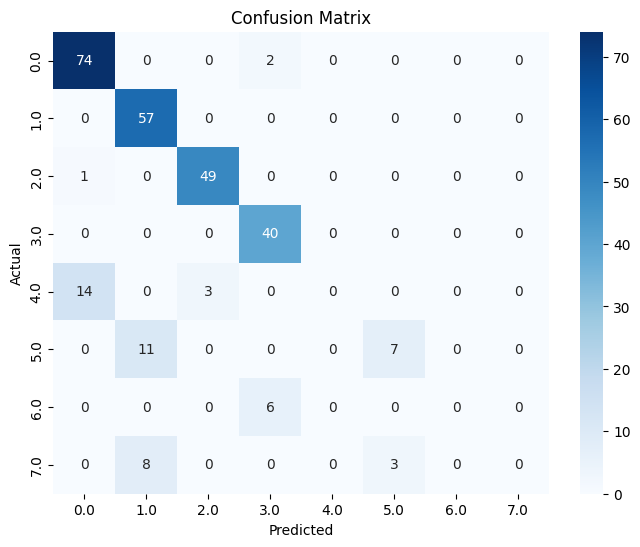

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

def plot_confusion_matrix(predictions, label_col="label", prediction_col="prediction"):
    # Extract true and predicted labels
    y_true = [row[label_col] for row in predictions.select(label_col).collect()]
    y_pred = [row[prediction_col] for row in predictions.select(prediction_col).collect()]

    # Compute confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Plot for Naive Bayes
plot_confusion_matrix(predictions)

# Plot for MLP
# plot_confusion_matrix(mlp_predictions)

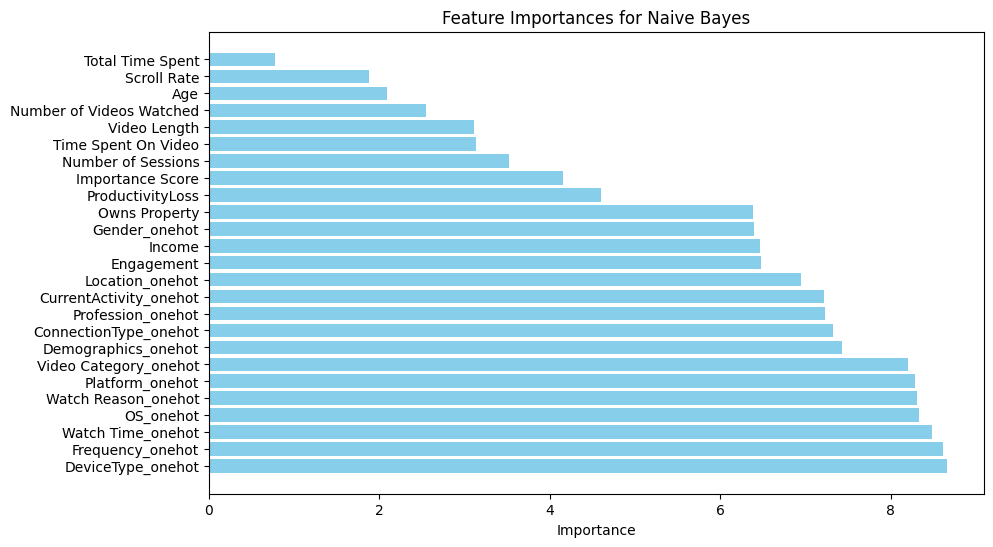

In [38]:
from pyspark.ml.classification import NaiveBayes
import numpy as np
import matplotlib.pyplot as plt

tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = tw_df.withColumn(
    "Addiction Category",
    when((tw_df["Addiction Level"] >= 0) & (tw_df["Addiction Level"] <= 2), "Low")
    .when((tw_df["Addiction Level"] >= 3) & (tw_df["Addiction Level"] <= 5), "Medium")
    .when((tw_df["Addiction Level"] >= 6) & (tw_df["Addiction Level"] <= 7), "High")
)
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Define categorical columns
categorical_columns = [
    "Gender", "Location", "Profession", "Demographics", "Platform",
    "Video Category", "Frequency", "Watch Reason", "DeviceType",
    "OS", "Watch Time", "CurrentActivity", "ConnectionType"
]

# Use StringIndexer to index categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_columns]

# Use OneHotEncoder to one-hot encode the indexed categorical columns
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_onehot") for c in categorical_columns]

# Combine all numerical columns into a feature vector
feature_columns = [
    "Age", "Income", "Owns Property", "Total Time Spent", "Number of Sessions",
    "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
    "Number of Videos Watched", "Scroll Rate", "ProductivityLoss",
] + [col + "_onehot" for col in categorical_columns]  # Add one-hot encoded categorical columns

# Assemble all features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Index the target column (Addiction Level)
label_indexer = StringIndexer(inputCol="Addiction Category", outputCol="label")

# Create a pipeline with indexers, encoders, assembler, and label indexer
pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer])

# Transform the data using the pipeline
data_transformed = pipeline.fit(tw_df).transform(tw_df)

# Split the data into training and test sets
train_data, test_data = data_transformed.randomSplit([0.7, 0.3], seed=1)

# Train the Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")
model = nb.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

    # Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Extract the `theta` coefficients (the likelihoods for each feature)
theta = model.theta

# `theta` is a DenseMatrix: Each row represents a class, and each column represents a feature's likelihood
# We need to calculate the magnitude of each feature's likelihood across all classes
theta_abs = np.abs(theta.toArray())  # Convert to numpy array and take the absolute value of the coefficients

# Calculate the average magnitude for each feature across all classes
feature_importances = np.mean(theta_abs, axis=0)

# Get the feature names (you can extract them from the VectorAssembler inputCols)
feature_names = feature_columns  # You already defined `feature_columns` before

# Sort the features by their importance
sorted_feature_importance = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=False)

# Plot the feature importances
def plot_feature_importances(feature_importances, title="Feature Importances for Naive Bayes"):
    features, importances = zip(*feature_importances)
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances, color="skyblue")
    plt.xlabel("Importance")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importances(sorted_feature_importance)

with just the most important features

In [55]:
from pyspark.ml.classification import NaiveBayes
import numpy as np
import matplotlib.pyplot as plt

tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = tw_df.withColumn(
    "Addiction Category",
    when((tw_df["Addiction Level"] >= 0) & (tw_df["Addiction Level"] <= 2), "Low")
    .when((tw_df["Addiction Level"] >= 3) & (tw_df["Addiction Level"] <= 5), "Medium")
    .when((tw_df["Addiction Level"] >= 6) & (tw_df["Addiction Level"] <= 7), "High")
)
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Define categorical columns
categorical_columns = [
     "Demographics", "Platform",
    "Video Category", "Frequency",
    "OS", "Watch Time",
]

# Use StringIndexer to index categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_columns]

# Use OneHotEncoder to one-hot encode the indexed categorical columns
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_onehot") for c in categorical_columns]

# Combine all numerical columns into a feature vector
feature_columns = [] + [col + "_onehot" for col in categorical_columns]  # Add one-hot encoded categorical columns

# Assemble all features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Index the target column (Addiction Level)
label_indexer = StringIndexer(inputCol="Addiction Category", outputCol="label")

# Create a pipeline with indexers, encoders, assembler, and label indexer
pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer])

# Transform the data using the pipeline
data_transformed = pipeline.fit(tw_df).transform(tw_df)

# Split the data into training and test sets
train_data, test_data = data_transformed.randomSplit([0.7, 0.3], seed=1)

# Train the Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")
model = nb.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Accuracy: 0.77
Precision: 0.78
Recall: 0.77
F1 Score: 0.77


**Multilayer Perceptron classification**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Define categorical columns
categorical_columns = [
    "Gender", "Location", "Profession", "Demographics", "Platform",
    "Video Category", "Frequency", "Watch Reason", "DeviceType",
    "OS", "Watch Time", "CurrentActivity", "ConnectionType"
]

# Use StringIndexer to index categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_columns]

# Combine all numerical columns into a feature vector
feature_columns = [
    "Age", "Income", "Owns Property", "Total Time Spent", "Number of Sessions",
    "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
    "Number of Videos Watched", "Scroll Rate", "Self Control",
] + [col + "_index" for col in categorical_columns]  # Add indexed categorical columns

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the MLP Classifier
# Define the layers for the MLP: [input layer, hidden layer(s), output layer]
# len(feature_columns) features, 5 neurons in the hidden layer, and 7 types of output for addiction level
layers = [len(feature_columns), 5, 5, 8]

mlp = MultilayerPerceptronClassifier(labelCol="Addiction Level", featuresCol="features", layers=layers, seed=1)

# Build the pipeline
pipeline = Pipeline(stages=indexers + [assembler, mlp])

# Split the data into training and test sets
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train the model
mlp_model = pipeline.fit(train_data)

# Make predictions
predictions = mlp_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Addiction Level", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")



Test Accuracy = 0.2073


using categorical addiction levels (low, med, high)

In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = tw_df.withColumn(
    "Addiction Category",
    when((tw_df["Addiction Level"] >= 0) & (tw_df["Addiction Level"] <= 2), "Low")
    .when((tw_df["Addiction Level"] >= 3) & (tw_df["Addiction Level"] <= 5), "Medium")
    .when((tw_df["Addiction Level"] >= 6) & (tw_df["Addiction Level"] <= 7), "High")
)
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Define categorical columns
categorical_columns = [
    "Gender", "Location", "Profession", "Demographics", "Platform",
    "Video Category", "Frequency", "Watch Reason", "DeviceType",
    "OS", "Watch Time", "CurrentActivity", "ConnectionType"
]

# Use StringIndexer to index categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_columns]

# Index the target column (Addiction Category)
label_indexer = StringIndexer(inputCol="Addiction Category", outputCol="label")

# Combine all numerical columns into a feature vector
feature_columns = [
    "Age", "Income", "Owns Property", "Total Time Spent", "Number of Sessions",
    "Video Length", "Engagement", "Importance Score", "Time Spent On Video",
    "Number of Videos Watched", "Scroll Rate",
] + [col + "_index" for col in categorical_columns]  # Add indexed categorical columns


# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the MLP Classifier
# Define the layers for the MLP: [input layer, hidden layer(s), output layer]
# len(feature_columns) features, 5 neurons in the hidden layer, and 7 types of output for addiction level
layers = [len(feature_columns), 5, 5, 8]

mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", layers=layers, seed=1)

# Build the pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler, mlp])

# Split the data into training and test sets
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train the model
mlp_model = pipeline.fit(train_data)

# Make predictions
predictions = mlp_model.transform(test_data)

# Evaluate the model with different metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1_score = evaluator.setMetricName("f1").evaluate(predictions)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")

Test Accuracy: 0.5200
Test Precision: 0.2704
Test Recall: 0.5200
Test F1 Score: 0.3558


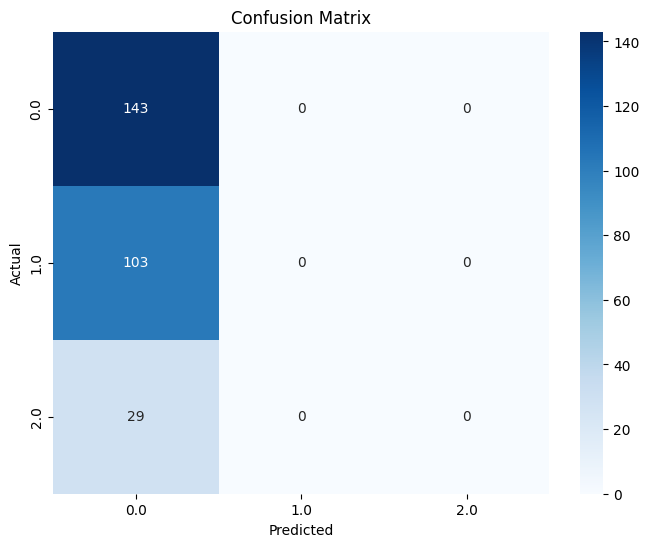

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

def plot_confusion_matrix(predictions, label_col="label", prediction_col="prediction"):
    # Extract true and predicted labels
    y_true = [row[label_col] for row in predictions.select(label_col).collect()]
    y_pred = [row[prediction_col] for row in predictions.select(prediction_col).collect()]

    # Compute confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(predictions)


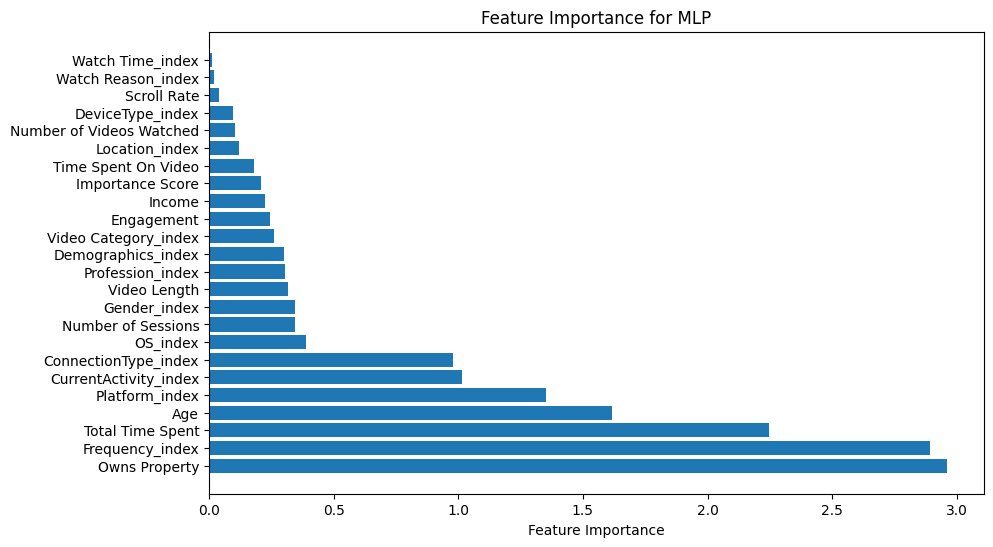

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Extract weights from the MLP model (weights from the first layer)
weights = mlp_model.stages[-1].weights  # Getting the weights from the last model in the pipeline (MLP classifier)

# Convert weights to a numpy array
weights_array = weights.toArray()

# If the model has multiple hidden layers, weights_array may be multi-dimensional.
# For a simple case, we'll only look at the first layer's weights (connections from input features to the first hidden layer).
# In case of multiple layers, the first column corresponds to the weights of the features in the first hidden layer.

# Get the absolute values of the weights (you can use absolute values as a proxy for importance)
feature_importances = np.abs(weights_array)  # In case the weights array is 2D, use absolute values across all dimensions

# Summing the weights of each feature across all neurons in the first hidden layer
# If you have multiple layers, sum over the neurons in the first hidden layer.
if len(weights_array.shape) > 1:
    feature_importances = np.sum(feature_importances, axis=1)

# Sort the feature importances
sorted_features = sorted(zip(feature_columns, feature_importances), key=lambda x: x[1], reverse=True)

# Plot the feature importances
features, importances = zip(*sorted_features)
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for MLP')
plt.show()


with just the most important features

In [53]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


tw_df = spark.read.csv("Time-Wasters on Social Media.csv", header=True, inferSchema=True)
tw_df = tw_df.withColumn(
    "Addiction Category",
    when((tw_df["Addiction Level"] >= 0) & (tw_df["Addiction Level"] <= 2), "Low")
    .when((tw_df["Addiction Level"] >= 3) & (tw_df["Addiction Level"] <= 5), "Medium")
    .when((tw_df["Addiction Level"] >= 6) & (tw_df["Addiction Level"] <= 7), "High")
)
tw_df = normalizeColumns(["Income","Engagement"], tw_df)
# Define categorical columns
categorical_columns = [
    "Platform", "Frequency", "CurrentActivity",
]

# Use StringIndexer to index categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index") for c in categorical_columns]

# Index the target column (Addiction Category)
label_indexer = StringIndexer(inputCol="Addiction Category", outputCol="label")

# Combine all numerical columns into a feature vector
feature_columns = [
    "Age", "Owns Property", "Total Time Spent",
] + [col + "_index" for col in categorical_columns]  # Add indexed categorical columns


# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the MLP Classifier
# Define the layers for the MLP: [input layer, hidden layer(s), output layer]
# len(feature_columns) features, 5 neurons in the hidden layer, and 7 types of output for addiction level
layers = [len(feature_columns), 5, 5, 8]

mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", layers=layers, seed=1)

# Build the pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler, mlp])

# Split the data into training and test sets
[train_data, test_data] = tw_df.randomSplit([0.7, 0.3], seed=1)

# Train the model
mlp_model = pipeline.fit(train_data)

# Make predictions
predictions = mlp_model.transform(test_data)

# Evaluate the model with different metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
f1_score = evaluator.setMetricName("f1").evaluate(predictions)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")


Test Accuracy: 0.5200
Test Precision: 0.2704
Test Recall: 0.5200
Test F1 Score: 0.3558
